### Ravelin


Test Repo: https://github.com/unravelin/code-test-data-science


- Transform the json profiles into a dataframe of feature vectors.
- Provide exploratory analysis of the dataset, and to summarise and explain the key trends in the data, explaining which factors appear to be most important in predicting fraud.
- Construct a model to predict if a customer is fraudulent based on their profile.
- Report on the models success and show what features are most important in that model.


**Please don't spend more than 3-4 hours on this task**. You may find that there are more aspects of the data that you can realistically investigate in that time, and that's fine. If that is the case, please just describe what your next steps might be if there were more time allocated to the task.

My break down:
- EDA: 2-2.5 hrs
- Modelling: 30 mins
- Writeup : 30-40 mins

### Data Loading

The given format for dataset is a standard json format. But inside all columns except fraudulent there is nesting of json's. This will require json normalization.

There are 168 customers in this dataset. For each customer, there is an associated list of orders, paymentMethods and transactions. 

- Normalize each of the jsons for each customer.

After normalization, there are 641 transactions with 18 of these missing `transactions` and `orders`.



In [17]:
import pandas as pd
import json
import numpy as np
import re

In [18]:
df = pd.read_json('customers.json', lines=True)
df.head()

,fraudulent,customer,orders,paymentMethods,transactions
0,False,"{'customerEmail': 'josephhoward@yahoo.com', 'c...","[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb..."
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'c...","[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg..."
2,False,"{'customerEmail': 'andersonwilliam@yahoo.com',...","[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3..."
3,False,"{'customerEmail': 'rubenjuarez@yahoo.com', 'cu...","[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz..."
4,True,"{'customerEmail': 'uchen@malone.com', 'custome...","[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h..."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fraudulent      168 non-null    bool  
 1   customer        168 non-null    object
 2   orders          168 non-null    object
 3   paymentMethods  168 non-null    object
 4   transactions    168 non-null    object
dtypes: bool(1), object(4)
memory usage: 5.5+ KB


In [20]:
def prepare_data(df, drop=True):
    df = df.join(pd.json_normalize(df.customer))
    if drop:
        df.drop(['customer'], axis=1, inplace=True)
    new_df = pd.DataFrame()
    for i in range(len(df)):
        t = pd.json_normalize(df.transactions[i])
        p = pd.json_normalize(df.paymentMethods[i])
        o = pd.json_normalize(df.orders[i])
        if len(t) != 0:
            t = p.merge(t, on='paymentMethodId')
            t = o.merge(t, on='orderId')
        else:
            t = p
        t = t.join(df.iloc[np.arange(i, i+1).repeat(len(t))].reset_index())
        if i == 0:
            new_df = t
        else:
            new_df = pd.concat([new_df, t], ignore_index=True)
    if drop:
        new_df.drop(['orders', 'paymentMethods', 'transactions', 'index'], axis=1, inplace=True)
    new_df['mailprovider'] = new_df['customerEmail'].apply(lambda x : x.split("@")[1].split(".")[0])
    new_df['order_abbv'] = new_df['orderShippingAddress'].apply(lambda x : re.sub(r"[^A-Za-z]+", '', x.split(",")[-1]) if isinstance(x, str) else x)
    new_df['customer_abbv'] = new_df['customerBillingAddress'].apply(lambda x : re.sub(r"[^A-Za-z]+", '', x.split(",")[-1]) if isinstance(x, str) else x)
    new_df['email_len'] = new_df['customerEmail'].apply(lambda x : len(x))
    new_df['order_add_len'] = new_df['orderShippingAddress'].apply(lambda x : len(x) if isinstance(x, str) else 0)
    new_df['customer_add_len'] = new_df['customerBillingAddress'].apply(lambda x : len(x) if isinstance(x, str) else 0)
    return new_df

In [21]:
new_df = prepare_data(df)

In [22]:
new_df.head()

,orderId,orderAmount,orderState,orderShippingAddress,paymentMethodId,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,transactionId,transactionAmount,transactionFailed,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,mailprovider,order_abbv,customer_abbv,email_len,order_add_len,customer_add_len
0,vjbdvd,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",wt07xm68b,True,card,JCB 16 digit,Citizens First Banks,a9lcj51r,18.0,False,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",yahoo,CA,CA,22,38,38
1,yp6x27,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",wt07xm68b,True,card,JCB 16 digit,Citizens First Banks,y4wcv03i,26.0,False,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",yahoo,CA,CA,22,38,38
2,nlghpa,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",41ug157xz,False,bitcoin,American Express,Bastion Banks,5mi94sfw,45.0,False,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,yahoo,CA,NM,22,44,55
3,uw0eeb,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,41ug157xz,False,bitcoin,American Express,Bastion Banks,br8ba1nu,23.0,False,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,yahoo,NM,NM,22,55,55
4,bn44oh,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",y3xp697jx,True,bitcoin,VISA 16 digit,Solace Banks,a33145ss,43.0,True,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,yahoo,FM,NM,22,41,55


In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   orderId                           623 non-null    object 
 1   orderAmount                       623 non-null    float64
 2   orderState                        623 non-null    object 
 3   orderShippingAddress              623 non-null    object 
 4   paymentMethodId                   641 non-null    object 
 5   paymentMethodRegistrationFailure  641 non-null    object 
 6   paymentMethodType                 641 non-null    object 
 7   paymentMethodProvider             641 non-null    object 
 8   paymentMethodIssuer               641 non-null    object 
 9   transactionId                     623 non-null    object 
 10  transactionAmount                 623 non-null    float64
 11  transactionFailed                 623 non-null    object 
 12  fraudule

In [24]:
new_df.describe()

,orderAmount,transactionAmount,email_len,order_add_len,customer_add_len
count,623.000000,623.000000,641.000000,641.000000,641.000000
mean,34.598716,34.598716,21.366615,45.539782,46.589704
std,20.360247,20.360247,4.108841,10.823530,8.129911
min,10.000000,10.000000,11.000000,0.000000,23.000000
25%,21.000000,21.000000,19.000000,41.000000,41.000000
50%,34.000000,34.000000,20.000000,47.000000,47.000000
75%,45.000000,45.000000,24.000000,53.000000,53.000000
max,353.000000,353.000000,35.000000,62.000000,65.000000


### EDA

Looking inside the dataset,

- What is distribution of target variable?
    - Surprisingly, almost equal distribution of positive (41.5%) and negative (58.5%) class present. Fraud detection always comes with the problem of imbalance dataset. Here, we got lucky.
- Which paymentMethods are associated with fraudulent transactions?
    - Bitcoin has highest fraud/non-fraud ratio while paypal is lowest. Apple pay and card method have almost the same ratio.
- Which issuer is likely to be associated with fraud transactions?
    - There are some issuers with single letter which are classified 100% fraud.
    - From the banks, CFB and BTC are more likely to have fraud transactions as compared to the rest.
- Which paymentprovider is likely to have more frauds?
    - Visa 13 and Voyager are more likely to have more frauds transactions as compared to non-fraud transactions. Rest all provider have about 60%-70% valid transactions vs 40%-30% fraud transactions.

- Interesting plot of transactionState with frauds.
    - There seems to be almost same distribution as that of target when transactionState is `False`. 
    - `Will this create a data leakage?` (being a sole predictor of whether transaction is fraud or not)

- Similar plot for orderState
    - Same distribution as that of target is observed when orderState is `failed` or `fulfilled`. 
    - Distribution is different only when orderState is `pending`

 
- Some of the orderAmount are missing, removing those OrderAmount and TransactionAmount are same. How are amounts associated with frauds? (very interesting)
    - There is one order which has highest price of 353 classified as fraud. Rest all amount lies in range of 10-80.
    - Removing that outlier, there is a strong consensus all `amount >= 50` classified as `fraud`. (so cool)
    - Besides this there are all small amounts < 50 that contains fraud transactions.



---

We do some feature engineering
- get city abbrevation associated with order billing address and customer billing address.
- Find length of email address
- Length of order and customer billing address
- Get the email provider from customerEmail.

**Analysis on these new features**

- City abbrevations for order and customer billing address
    - Interestingly there are all combinations of observations between frauds and non-frauds for the abbrevations
    - some of the abbrevations have 100% frauds and some of them have 100% non-fraud transactions.
    - some of have more frauds than non-frauds and vice versa
    - some of them have equal amount of frauds vs non-frauds.

- Mailprovider associated with fraudulent transactions
    - There are some sketchy providers such as `1jckcxs7s..`, etc. which are 100% classified as fraud.
    - Interestingly, `gmail` has more frauds as compared non-frauds.
    - Mostly, the plots show that most of the provider is either completely fraud or completely non-fraud.
    - Small majority are partially balanced.


- For email length vs fraud
    - If email length < 15, there is a fraud, else fraud and non-fraud are mixed for lengths>15.

- For order address len vs fraud
    - Orderbilling adress length lies between 20 to 60. There is no clear distinction between what length is required for transaction to be classified as frauds or non-fraud.

- For customer address len vs fraud
    - If customer address length is < 35 or > 60, all transactions are valid. The range of customer address lies between 5 to 65.
    - For rest, there is mix of fraud and non-fraud.


---

From correlation matrix, 
    - There is strong correlation between fraudulent and orderAmount.
    - Slight with order address and customer address length
    - Very slight with email address length

---

- We also verify that the distribution of transactionState is same as target varible.
- Same analysis is done for various other columns.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (5, 7)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

False    0.585023
True     0.414977
Name: fraudulent, dtype: float64


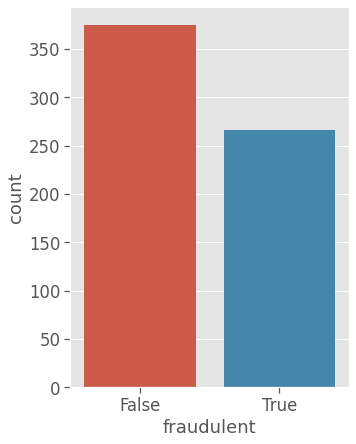

In [26]:
print(new_df['fraudulent'].value_counts(normalize=True))
sns.countplot(data=new_df, x='fraudulent')

In [27]:
#https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
def plot_percentage(x, y, data):
    percent_df = (data.groupby([x])[y]
                        .value_counts(normalize=True)
                        .rename('percentage')
                        .mul(100)
                        .reset_index()
                        .sort_values(x))
    p = sns.barplot(x=x, y="percentage", hue=y, data=percent_df)
    _ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
    plt.show()

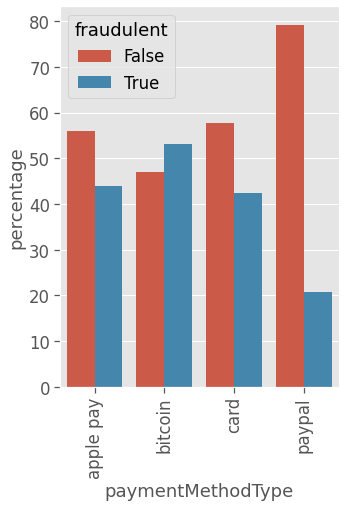

In [28]:
# sns.countplot(x="paymentMethodType", hue="fraudulent", data=new_df)
plot_percentage(x="paymentMethodType", y="fraudulent", data=new_df)

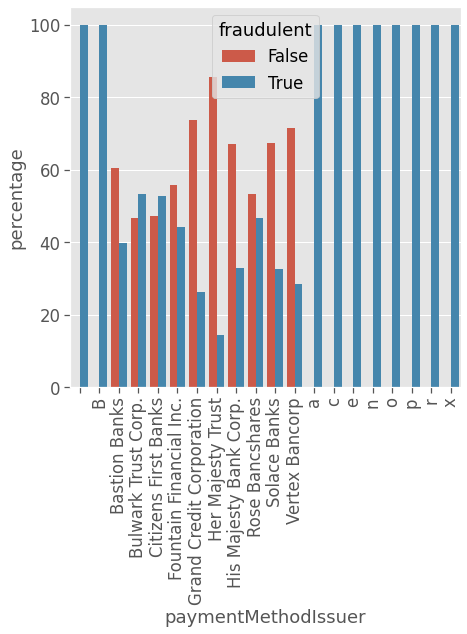

In [29]:
# sns.countplot(x="paymentMethodIssuer", hue="fraudulent", data=new_df)
# plt.xticks(rotation=90)
plt.figure(figsize=(7, 7))
plot_percentage(x="paymentMethodIssuer", y="fraudulent", data=new_df)

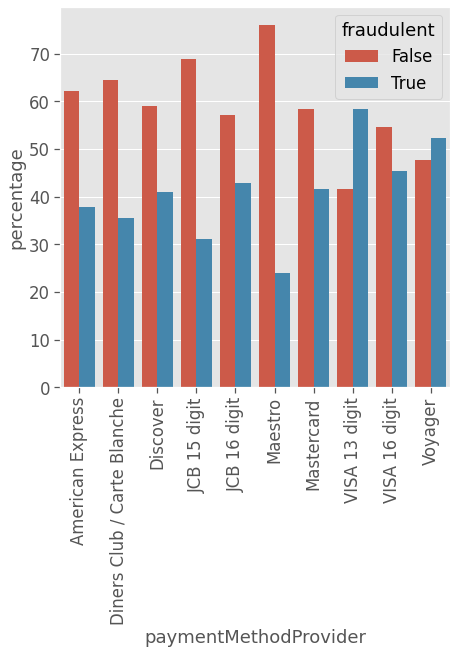

In [30]:
# sns.countplot(x="paymentMethodProvider", hue="fraudulent", data=new_df)
# plt.xticks(rotation=90)

plt.figure(figsize=(7, 7))
plot_percentage(x="paymentMethodProvider", y="fraudulent", data=new_df)

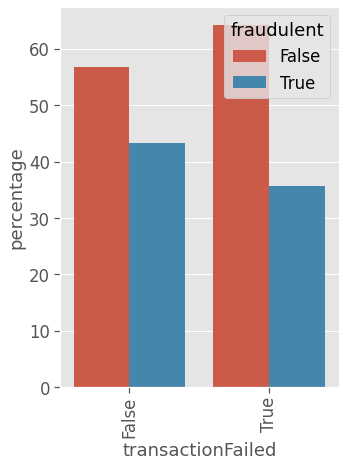

In [31]:
# sns.countplot(x="transactionFailed", hue="fraudulent", data=new_df)

plot_percentage(x="transactionFailed", y="fraudulent", data=new_df)

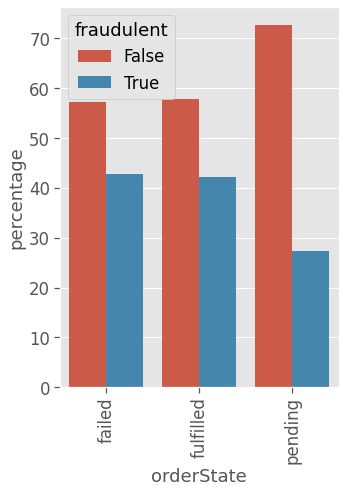

In [32]:
# sns.countplot(x="orderState", hue="fraudulent", data=new_df)

plot_percentage(x="orderState", y="fraudulent", data=new_df)

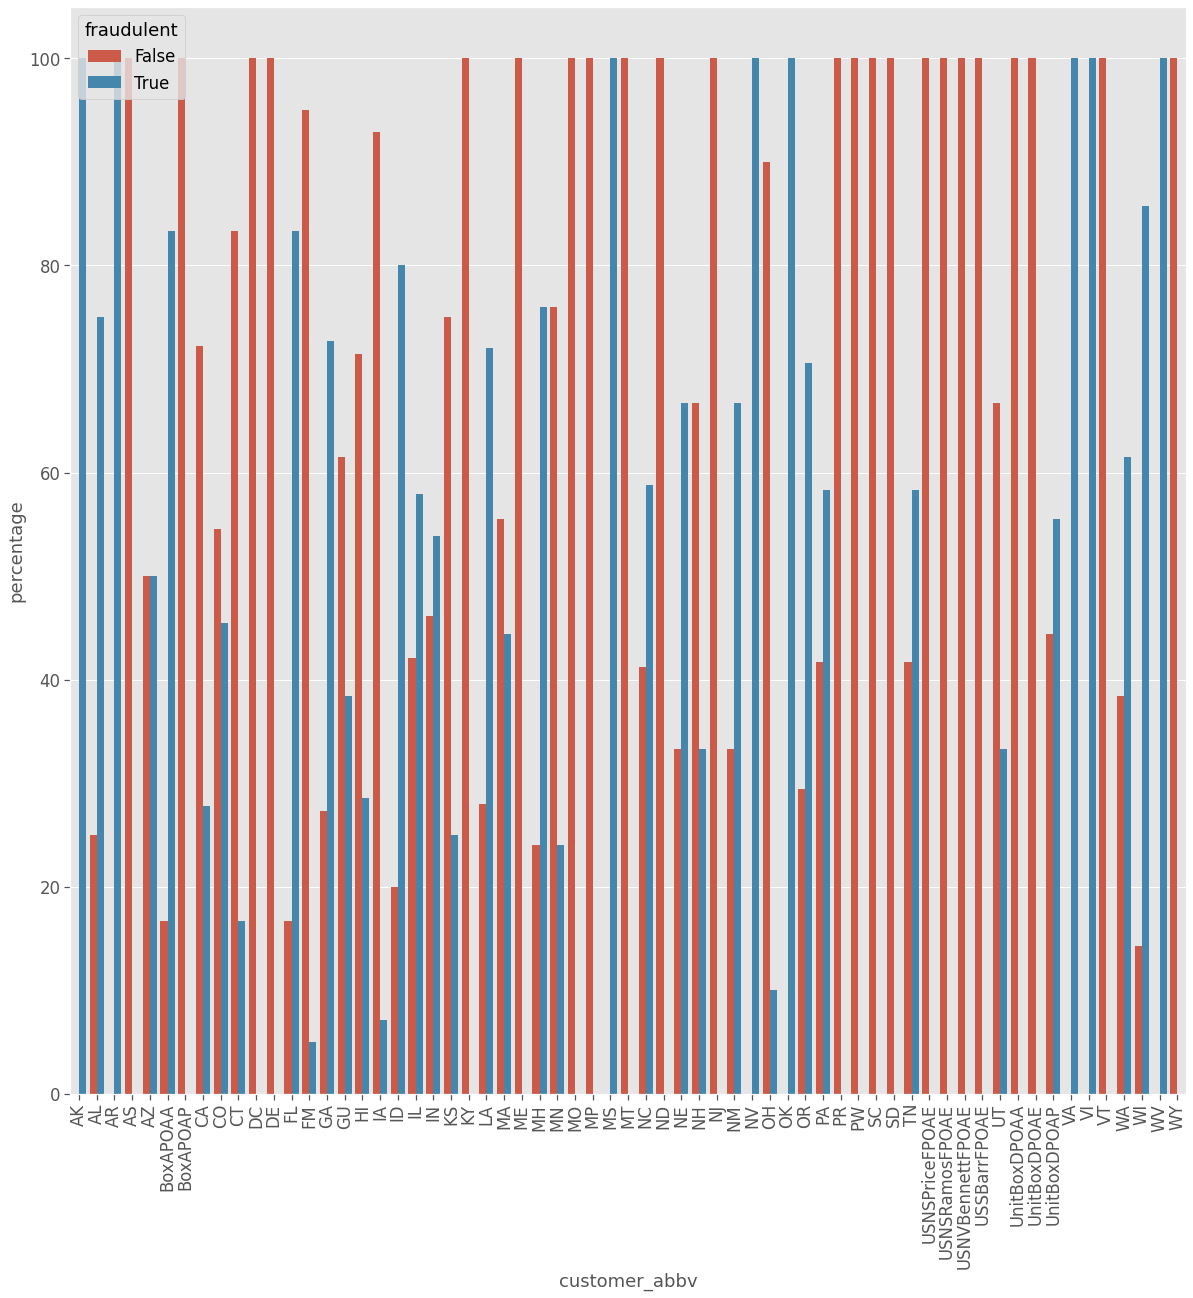

In [33]:
plt.figure(figsize=(20, 20))
# sns.countplot(y="customer_abbv", hue="fraudulent", data=new_df)

plot_percentage(x="customer_abbv", y="fraudulent", data=new_df)

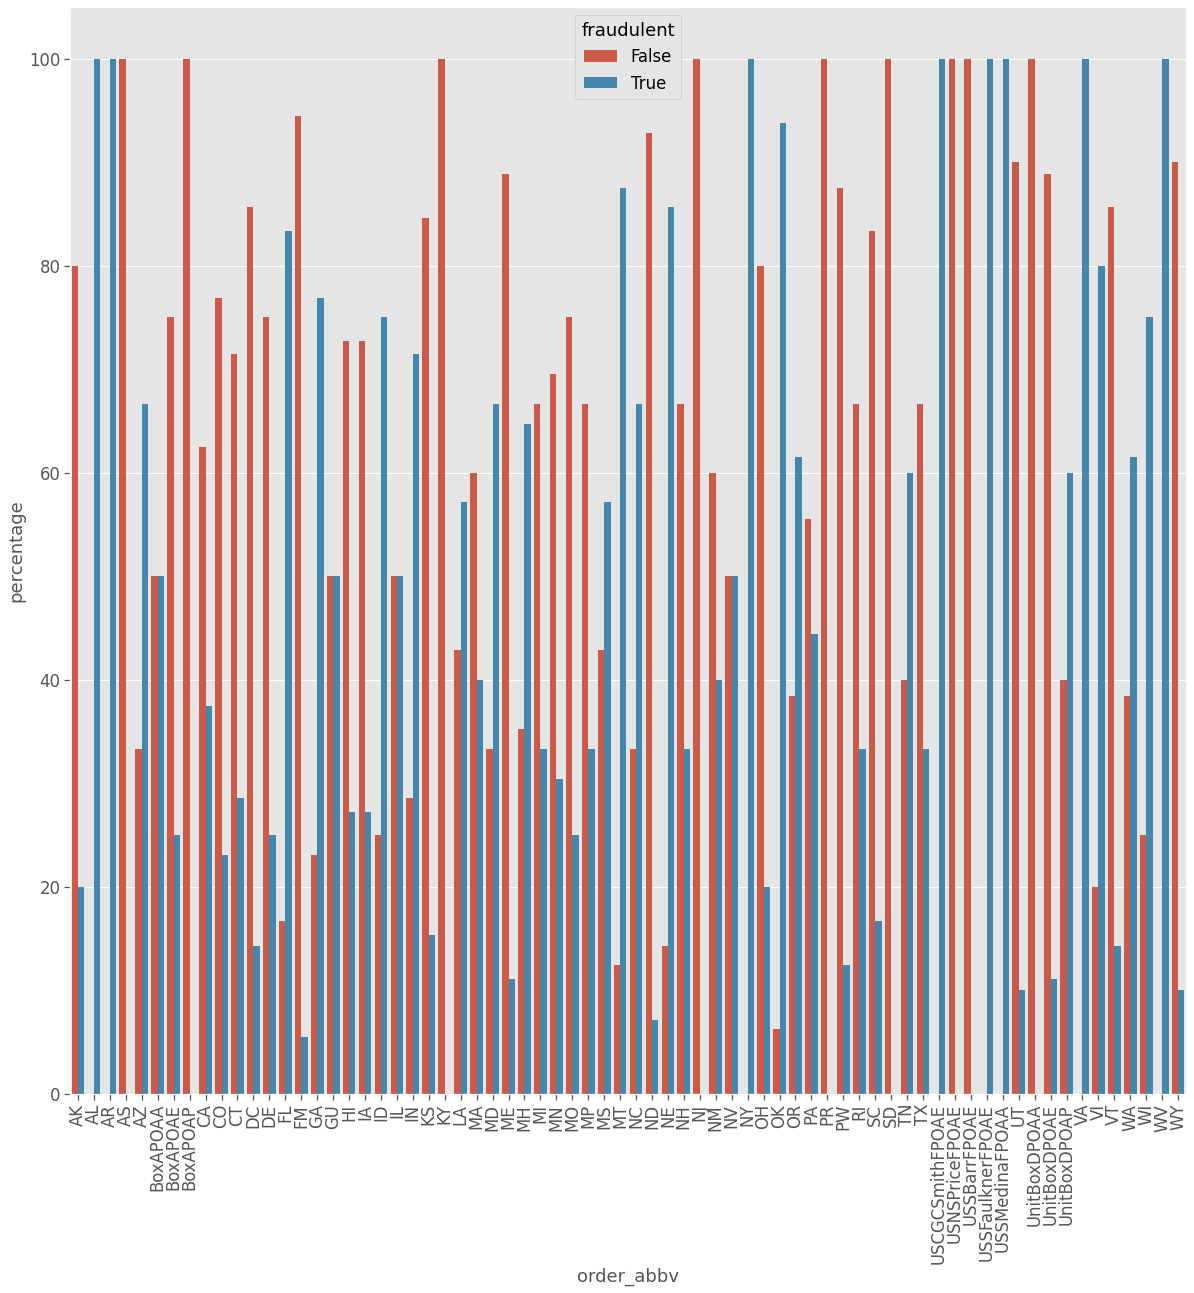

In [34]:
plt.figure(figsize=(20, 20))
# sns.countplot(y="order_abbv", hue="fraudulent", data=new_df)

plot_percentage(x="order_abbv", y="fraudulent", data=new_df)

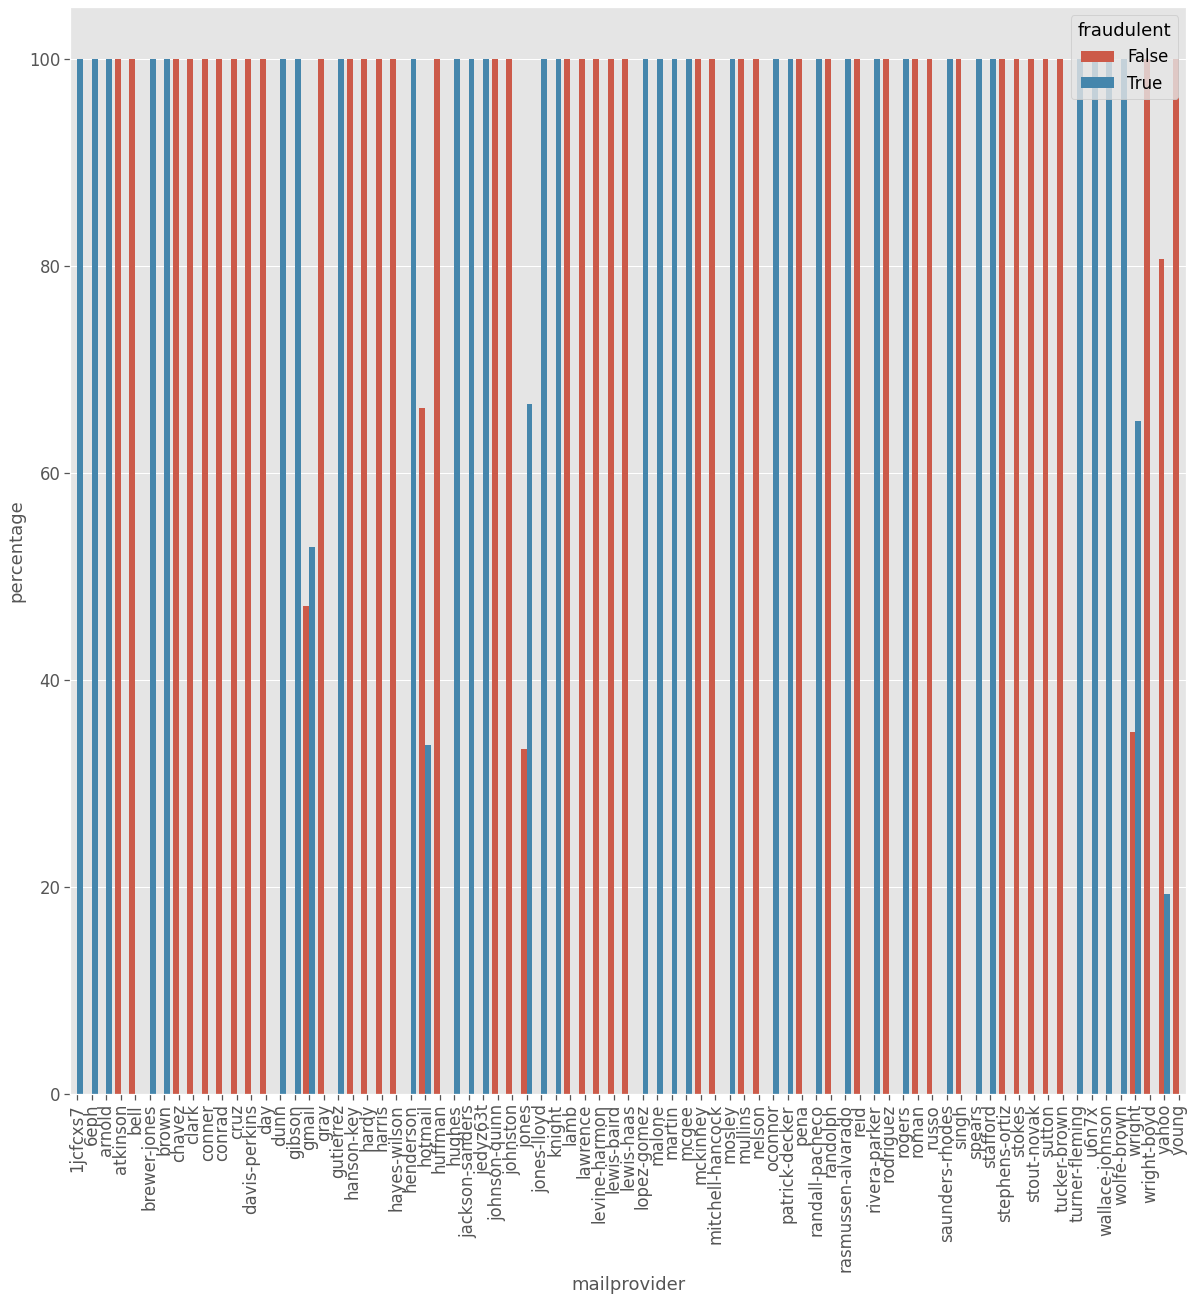

In [35]:
plt.figure(figsize=(20, 20))
# sns.countplot(y="mailprovider", hue="fraudulent", data=new_df)

plot_percentage(x="mailprovider", y="fraudulent", data=new_df)

In [36]:
non_nan_df = new_df.dropna()
np.array_equal(non_nan_df['orderAmount'], non_nan_df['transactionAmount'])

True

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


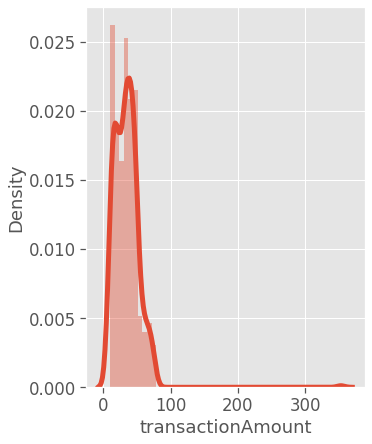

In [37]:
sns.distplot(non_nan_df['transactionAmount'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


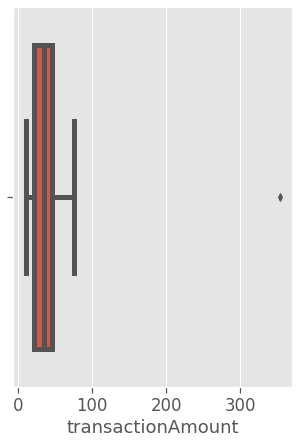

In [38]:
sns.boxplot(non_nan_df['transactionAmount'])

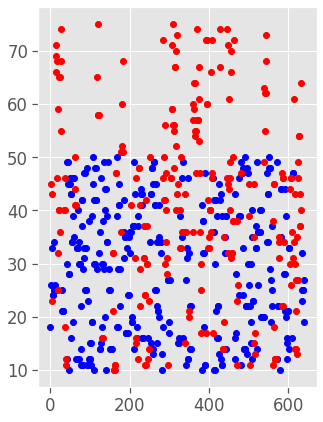

In [39]:
# plt.plot(non_nan_df.query('fraudulent == False')['orderAmount'], 'o', color='blue')
# plt.plot(non_nan_df.query('fraudulent == True')['orderAmount'], 'o', color='red')

non_max_val = non_nan_df[non_nan_df['orderAmount'] != 353.00]
plt.plot(non_max_val.query('fraudulent == False')['orderAmount'], 'o', color='blue')
plt.plot(non_max_val.query('fraudulent == True')['orderAmount'], 'o', color='red')

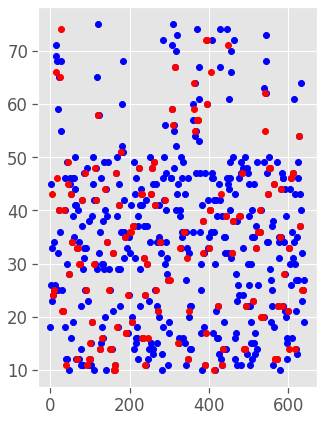

In [40]:
# plt.plot(non_nan_df.query('transactionFailed == False')['transactionAmount'], 'o', color='blue')
# plt.plot(non_nan_df.query('transactionFailed == True')['transactionAmount'], 'o', color='red')

non_max_val = non_nan_df[non_nan_df['orderAmount'] != 353.00]
plt.plot(non_max_val.query('transactionFailed == False')['transactionAmount'], 'o', color='blue')
plt.plot(non_max_val.query('transactionFailed == True')['transactionAmount'], 'o', color='red')

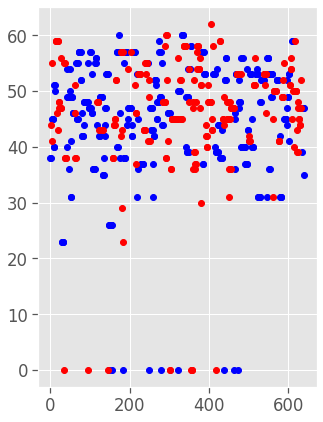

In [41]:
plt.plot(new_df.query('fraudulent == False')['order_add_len'], 'o', color='blue')
plt.plot(new_df.query('fraudulent == True')['order_add_len'], 'o', color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


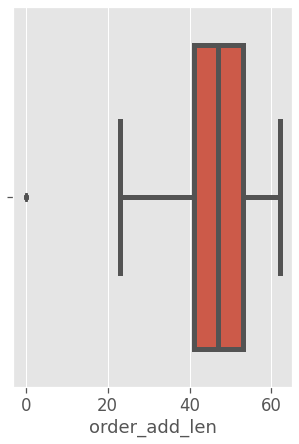

In [42]:
sns.boxplot(new_df['order_add_len'])

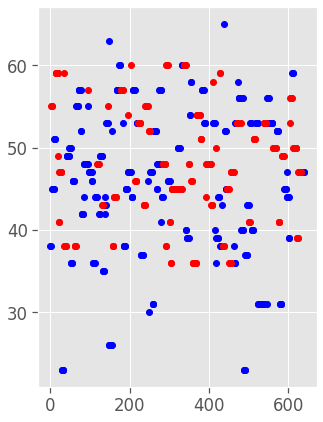

In [43]:
plt.plot(new_df.query('fraudulent == False')['customer_add_len'], 'o', color='blue')
plt.plot(new_df.query('fraudulent == True')['customer_add_len'], 'o', color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


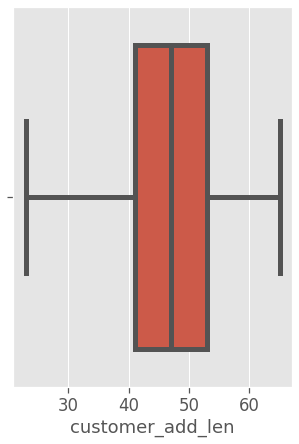

In [44]:
sns.boxplot(new_df['customer_add_len'])

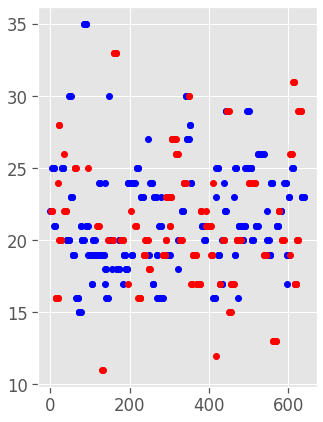

In [45]:
plt.plot(new_df.query('fraudulent == False')['email_len'], 'o', color='blue')
plt.plot(new_df.query('fraudulent == True')['email_len'], 'o', color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


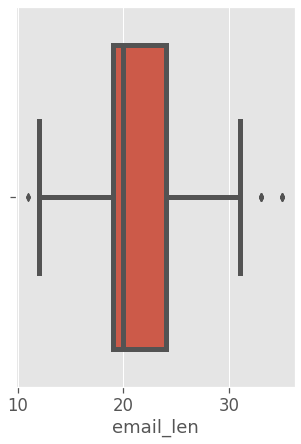

In [46]:
sns.boxplot(new_df['email_len'])

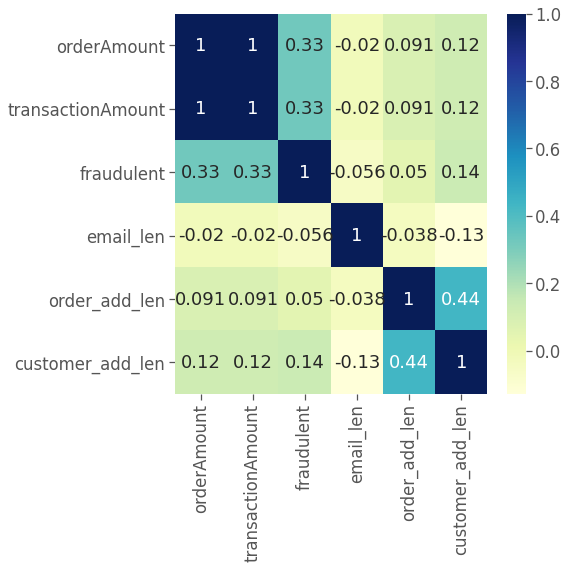

In [47]:
plt.figure(figsize=(7, 7))

# # creating mask 
# mask = np.triu(np.ones_like(new_df.corr())) 
# # plotting a triangle correlation heatmap 
# sns.heatmap(new_df.corr(), cmap="YlGnBu", annot=True, mask=mask) 

sns.heatmap(new_df.corr(), cmap="YlGnBu", annot=True) 

In [66]:
cols = ['orderState', 'transactionFailed', 'paymentMethodRegistrationFailure', 'paymentMethodType', 'email_len', 'order_add_len', 'customer_add_len', 'customer_abbv']
print('Fraudulent Distribution:\n', new_df['fraudulent'].value_counts(normalize=True))
print('-'*100)
for x in cols:
    print(pd.crosstab(new_df[x], new_df['fraudulent'], normalize='index').sort_values(by=[1], ascending=False).head(5))
    print('-'*100)

Fraudulent Distribution:
 False    0.58748
True     0.41252
Name: fraudulent, dtype: float64
----------------------------------------------------------------------------------------------------
fraudulent     False     True 
orderState                    
failed      0.571429  0.428571
fulfilled   0.577519  0.422481
pending     0.727273  0.272727
----------------------------------------------------------------------------------------------------
fraudulent            False     True 
transactionFailed                    
False              0.567033  0.432967
True               0.642857  0.357143
----------------------------------------------------------------------------------------------------
fraudulent                           False     True 
paymentMethodRegistrationFailure                    
True                              0.548780  0.451220
False                             0.593346  0.406654
-------------------------------------------------------------------------------------

In [49]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   orderId                           623 non-null    object 
 1   orderAmount                       623 non-null    float64
 2   orderState                        623 non-null    object 
 3   orderShippingAddress              623 non-null    object 
 4   paymentMethodId                   641 non-null    object 
 5   paymentMethodRegistrationFailure  641 non-null    object 
 6   paymentMethodType                 641 non-null    object 
 7   paymentMethodProvider             641 non-null    object 
 8   paymentMethodIssuer               641 non-null    object 
 9   transactionId                     623 non-null    object 
 10  transactionAmount                 623 non-null    float64
 11  transactionFailed                 623 non-null    object 
 12  fraudule

### Modelling


Coming to fun part

- Keeping everything very simple using 3 models logistic regression, random forest and extra trees and default parameters.
- Also check the results using calibrated models of the same.
- Best metric to track for fraud detection -> AUC
- Drop the id columns
- Drop orderState, transactionFailed -> (data leakage??) and orderAmount (repetition).
- Perform label encoding on categorical features
- Perform standard scaling on int and float columns
- To split dataset, GroupKFold with n_splits=5 is used. (No stratification is performed.)


**Results**

- Best results obtained from RF calibrated model -> AUC = 70%
- Calibration performs well instead of plain models.
- Shap plot for Logistic Regression, RF and ET
    - mail provider and transaction amount are important features.
    - high transaction amount gets classified as fraud -> consistent with our findings in EDA.

**Future Work**

- Date variable is not present (would be interesting to get this in dataset as well)
- Investigate role of data leakage features -> does it really happen?
- Instead of dropping address columns, use embeddings.
- Instead of GroupKFold use GroupKFold Stratified for splitting.
- Better models (lightgbm, xgboost, catboost, neural networks)

In [ ]:
!pip install shap -qq

In [51]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV

import shap

In [52]:
dropcols = ['orderId', 'paymentMethodId', 'transactionId', 'orderAmount', 'transactionFailed', 'orderState', 'orderShippingAddress', 'customerBillingAddress', 'paymentMethodRegistrationFailure']
lecols = ['customer_abbv', 'order_abbv', 'fraudulent', 'customerIPAddress', 'customerPhone', 'customerDevice', 'mailprovider', 'customerEmail', 'paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer']
# dummiescols = []
sscols = ['transactionAmount', 'order_add_len', 'customer_add_len', 'email_len']

target = 'fraudulent'

print("Before dropping length:", len(new_df), new_df.shape)
# better way to handle nan's -> add unknown for categorical columns
new_df = new_df.dropna()
print("After dropping na length:", len(new_df))
data_df = new_df.drop(dropcols, axis=1)
print("After dropping cols shape:", data_df.shape)

Before dropping length: 641 (641, 24)
After dropping na length: 623
After dropping cols shape: (623, 15)


In [53]:
le = LabelEncoder()

for c in lecols:
    data_df.loc[:, c]=  data_df[c].astype('str')
    data_df.loc[:, c]= le.fit_transform(data_df[c])

In [54]:
sc = StandardScaler()

for c in sscols:
    data_df.loc[:, c]= sc.fit_transform(np.array(data_df.loc[:, c]).reshape(-1, 1))   

In [76]:
data_df["gfold"] = -1
data_df = data_df.sample(frac=1).reset_index(drop=True)
y = data_df.fraudulent.values
groups = data_df['customerEmail'].values

In [77]:
splits = 5
group_kfold = GroupKFold(n_splits=splits)
for f, (t_, v_) in enumerate(group_kfold.split(data_df, y, groups)):
    data_df.loc[v_, 'gfold'] = f

In [78]:
for n in range(splits):
    print("Fold:", n) 
    print("Train:", data_df[data_df.gfold!=n].fraudulent.value_counts())
    print("Valid:", data_df[data_df.gfold==n].fraudulent.value_counts())

Fold: 0
Train: 0    299
1    199
Name: fraudulent, dtype: int64
Valid: 0    67
1    58
Name: fraudulent, dtype: int64
Fold: 1
Train: 0    301
1    197
Name: fraudulent, dtype: int64
Valid: 0    65
1    60
Name: fraudulent, dtype: int64
Fold: 2
Train: 0    288
1    210
Name: fraudulent, dtype: int64
Valid: 0    78
1    47
Name: fraudulent, dtype: int64
Fold: 3
Train: 0    290
1    209
Name: fraudulent, dtype: int64
Valid: 0    76
1    48
Name: fraudulent, dtype: int64
Fold: 4
Train: 0    286
1    213
Name: fraudulent, dtype: int64
Valid: 0    80
1    44
Name: fraudulent, dtype: int64


In [79]:
def train_models(df, splits:int=3, calibration:bool = False, 
                 model_name:str="LR", plot_importance:bool=True):
    '''
    Training various model and plot shap importances
    ----
    Args:
        x : transformed dataset
        calibration: whether to use calibrated models
        model_name: choose a model to run from ["LR", "RF", "ET"]
        plot_importance: whether to plot shap importance
    '''

    features = [f for f in df.columns if f not in ('gfold', 'fraudulent')]

    if model_name == "LR":
        model = linear_model.LogisticRegression()
    if model_name == "RF":
        model = ensemble.RandomForestClassifier()
    if model_name == "ET":
        model = ensemble.ExtraTreesClassifier()
    
    scores = []
    for fold in range(splits):
        df_train = df[df.gfold != fold].reset_index(drop=True)
        df_valid = df[df.gfold == fold].reset_index(drop=True)

        x_train, y_train = df_train[features], df_train.fraudulent.values
        x_valid, y_valid = df_valid[features], df_valid.fraudulent.values

        if calibration:
            model.fit(x_train, y_train)
            calibrator = CalibratedClassifierCV(model, cv='prefit')
            calibrator.fit(x_valid, y_valid)
            valid_preds = calibrator.predict_proba(x_valid)[:, 1]
            auc = metrics.roc_auc_score(y_valid, valid_preds)
            print(f"Model {model_name} Calibration: {calibration} Fold: {fold} AUC: {auc}")
            print(metrics.classification_report(y_valid, calibrator.predict(x_valid)))
        else:
            model.fit(x_train, y_train)
            valid_preds = model.predict_proba(x_valid)[:, 1]
            auc = metrics.roc_auc_score(y_valid, valid_preds)
            print(f"Model {model_name} Calibration: {calibration} Fold: {fold} AUC: {auc}")
            print(metrics.classification_report(y_valid, model.predict(x_valid)))
        scores.append(auc)

        if model_name in ["ET", "RF"] and plot_importance and fold==splits-1 and not calibration:
            shapvalues = shap.TreeExplainer(model).shap_values(x_train)
            shap.summary_plot(shapvalues, x_train, plot_type="bar") 
            plt.show()
            shap.summary_plot(shapvalues[1], x_train)
            plt.show()

        if model_name == "LR" and plot_importance and fold==splits-1 and not calibration:
            shapvalues = shap.LinearExplainer(model, x_train, feature_dependence="independent").shap_values(x_train)
            shap.summary_plot(shapvalues, x_train, plot_type="bar")

    scores = np.array(scores)
    print(f"Model {model_name} Mean AUC: {scores.mean()} STD AUC: {scores.std()}")

Model LR Calibration: False Fold: 0 AUC: 0.5589294904786413
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        67
           1       0.53      0.40      0.46        58

    accuracy                           0.56       125
   macro avg       0.55      0.55      0.54       125
weighted avg       0.56      0.56      0.55       125

Model LR Calibration: False Fold: 1 AUC: 0.6617948717948718
              precision    recall  f1-score   support

           0       0.60      0.80      0.68        65
           1       0.66      0.42      0.51        60

    accuracy                           0.62       125
   macro avg       0.63      0.61      0.60       125
weighted avg       0.63      0.62      0.60       125

Model LR Calibration: False Fold: 2 AUC: 0.7326786688488817
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        78
           1       0.56      0.51      0.53        47

  

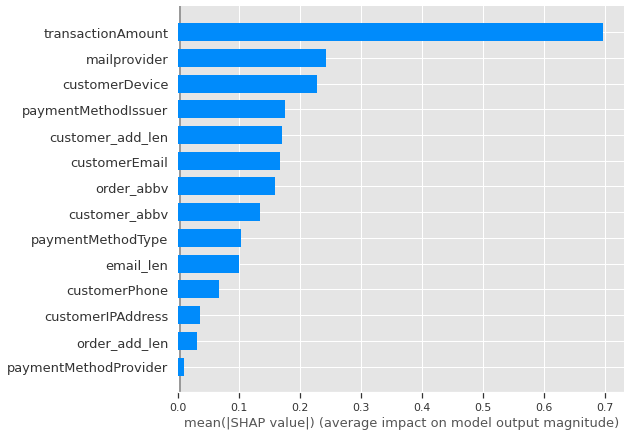

Model LR Mean AUC: 0.6502180862882747 STD AUC: 0.07720793806267748


In [80]:
train_models(data_df, splits, False, "LR")

In [81]:
train_models(data_df, splits, True, "LR")

Model LR Calibration: True Fold: 0 AUC: 0.5589294904786414
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        67
           1       0.52      0.38      0.44        58

    accuracy                           0.55       125
   macro avg       0.55      0.54      0.53       125
weighted avg       0.55      0.55      0.54       125

Model LR Calibration: True Fold: 1 AUC: 0.6617948717948718
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        65
           1       0.63      0.52      0.57        60

    accuracy                           0.62       125
   macro avg       0.63      0.62      0.62       125
weighted avg       0.63      0.62      0.62       125

Model LR Calibration: True Fold: 2 AUC: 0.7326786688488817
              precision    recall  f1-score   support

           0       0.73      0.87      0.80        78
           1       0.69      0.47      0.56        47

    a

Model RF Calibration: False Fold: 0 AUC: 0.5469634585692228
              precision    recall  f1-score   support

           0       0.60      0.82      0.70        67
           1       0.65      0.38      0.48        58

    accuracy                           0.62       125
   macro avg       0.63      0.60      0.59       125
weighted avg       0.62      0.62      0.60       125

Model RF Calibration: False Fold: 1 AUC: 0.7405128205128204
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        65
           1       0.81      0.50      0.62        60

    accuracy                           0.70       125
   macro avg       0.73      0.70      0.69       125
weighted avg       0.73      0.70      0.69       125

Model RF Calibration: False Fold: 2 AUC: 0.6572558647026732
              precision    recall  f1-score   support

           0       0.73      0.95      0.82        78
           1       0.83      0.40      0.54        47

  

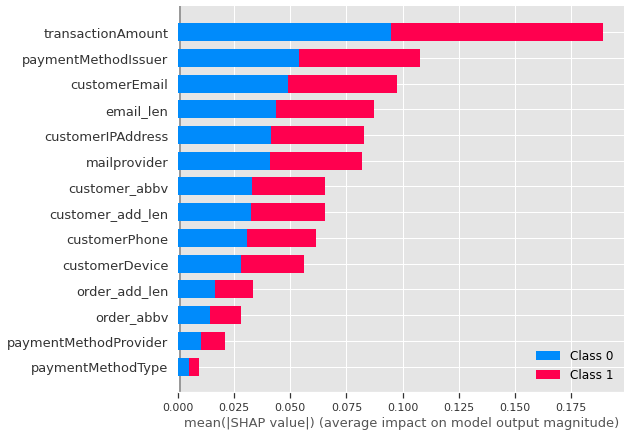

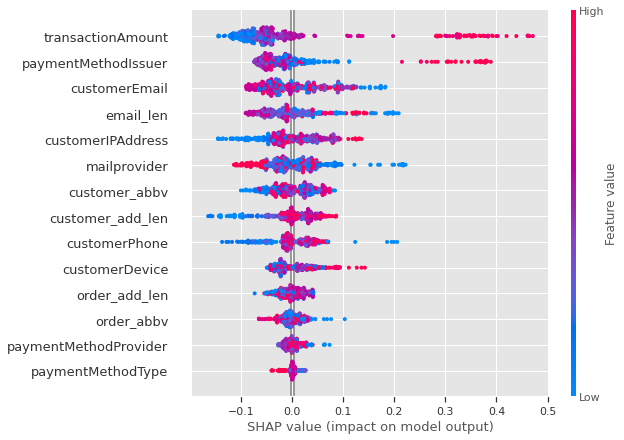

Model RF Mean AUC: 0.6980906671939449 STD AUC: 0.10128654974716796


In [82]:
train_models(data_df, splits, False, "RF")

In [83]:
train_models(data_df, splits, True, "RF")

Model RF Calibration: True Fold: 0 AUC: 0.5702521873391663
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        67
           1       0.62      0.36      0.46        58

    accuracy                           0.60       125
   macro avg       0.61      0.58      0.57       125
weighted avg       0.60      0.60      0.58       125

Model RF Calibration: True Fold: 1 AUC: 0.75
              precision    recall  f1-score   support

           0       0.68      0.83      0.74        65
           1       0.76      0.57      0.65        60

    accuracy                           0.70       125
   macro avg       0.72      0.70      0.70       125
weighted avg       0.71      0.70      0.70       125

Model RF Calibration: True Fold: 2 AUC: 0.6793507910529187
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        78
           1       0.77      0.43      0.55        47

    accuracy       

Model ET Calibration: False Fold: 0 AUC: 0.5739835306227483
              precision    recall  f1-score   support

           0       0.61      0.90      0.72        67
           1       0.73      0.33      0.45        58

    accuracy                           0.63       125
   macro avg       0.67      0.61      0.59       125
weighted avg       0.66      0.63      0.60       125

Model ET Calibration: False Fold: 1 AUC: 0.7621794871794871
              precision    recall  f1-score   support

           0       0.64      0.89      0.74        65
           1       0.79      0.45      0.57        60

    accuracy                           0.68       125
   macro avg       0.72      0.67      0.66       125
weighted avg       0.71      0.68      0.66       125

Model ET Calibration: False Fold: 2 AUC: 0.6854882705946536
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        78
           1       0.71      0.36      0.48        47

  

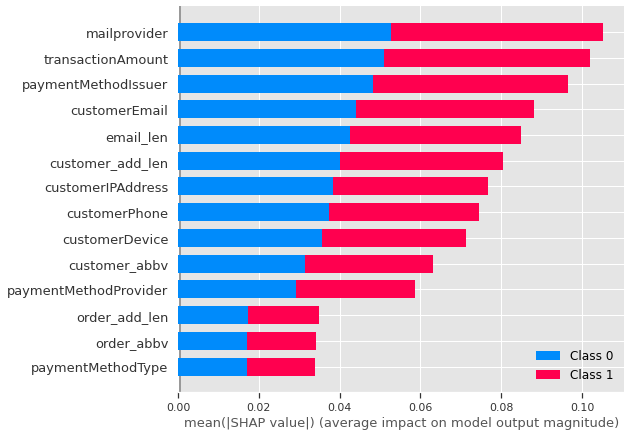

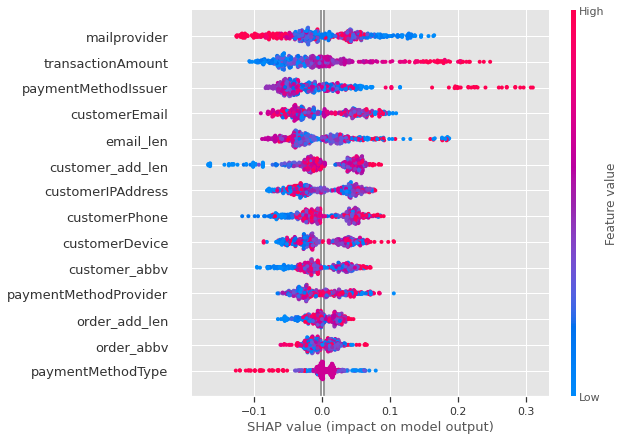

Model ET Mean AUC: 0.6828295599122327 STD AUC: 0.060854443168540905


In [84]:
train_models(data_df, splits, False, "ET")

In [85]:
train_models(data_df, splits, True, "ET")

Model ET Calibration: True Fold: 0 AUC: 0.5599588265568709
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        67
           1       0.72      0.36      0.48        58

    accuracy                           0.64       125
   macro avg       0.67      0.62      0.60       125
weighted avg       0.67      0.64      0.61       125

Model ET Calibration: True Fold: 1 AUC: 0.7823076923076924
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        65
           1       0.71      0.67      0.69        60

    accuracy                           0.71       125
   macro avg       0.71      0.71      0.71       125
weighted avg       0.71      0.71      0.71       125

Model ET Calibration: True Fold: 2 AUC: 0.6081560283687942
              precision    recall  f1-score   support

           0       0.66      0.91      0.76        78
           1       0.59      0.21      0.31        47

    a